In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier
from xgboost import plot_tree

from matplotlib import pyplot as plt

In [2]:
_DATA_TYPES = dict(
    PassengerId=int,
    Survived=int,
    Pclass=int,
    Title=str,
    Sex=str,
    Age=float,
    SibSp=int,#number of siblings/spouses
    Parch=int,#number of parents/children
    TicketTag=str,
    Fare=float,
    CabinTag=str,
    NumCabins=int,
    Embarked=str,
    )

In [3]:
class Preprocessor:
    """ Class to transform features,
    by ordinal encoding or scaling (or by doing nothing)
    """
    def __init__(self, columns):
        self.columns = columns
        self.transformers = []
        self.categorical_cols = []
        for i, col in enumerate(self.columns):
            if _DATA_TYPES[col] == str:
                # categorical
                self.transformers += [OrdinalEncoder()]
                self.categorical_cols += [i]
            elif _DATA_TYPES[col] == float:
                # numeric
                self.transformers += [StandardScaler()]
            else:
                # leave integers as they are
                self.transformers += [None]
    
    def fit(self, x, y=None):
        for i, tran in enumerate(self.transformers):
            if tran is None:
                continue
            data = x[:,i].reshape(-1,1)
            if i in self.categorical_cols:
                # convert to str to handle missing (np.nan -> 'nan')
                data = np.unique(data.astype(str))
                # allow for missing values even if none in training set
                data = np.array(list(data) + ['nan']).reshape(-1,1)
            tran.fit(data)
        return self
    
    def transform(self, x, y=None):
        out = []
        for i, tran in enumerate(self.transformers):
            data = x[:,i].reshape(-1,1)
            if tran is None:
                out += [data]
                continue
            if i in self.categorical_cols:
                data = data.astype(str)
            out += [tran.transform(data)]
        return np.hstack(out)
    
    def inverse_transform(self, x, y=None):
        out = []
        for i, tran in enumerate(self.transformers):
            data = x[:,i].reshape(-1,1)
            if tran is None:
                out += [data]
                continue
            out += [tran.inverse_transform(data)]
        return np.hstack(out)

In [4]:
df_train_val = pd.read_csv('features.train.csv',
                       index_col='PassengerId', dtype=_DATA_TYPES)
y = df_train_val.Survived.values #doesn't need encoding
df_train_val = df_train_val.drop('Survived', axis=1)
df_train_val

,Pclass,Title,Sex,Age,SibSp,Parch,TicketTag,Fare,CabinTag,NumCabins,Embarked
PassengerId,,,,,,,,,,,
1,3,Mr.,male,22.0,1,0,A/5,7.2500,NaN,0,S
2,1,Mrs.,female,38.0,1,0,PC,71.2833,C,1,C
3,3,Miss.,female,26.0,0,0,STON/O2.,7.9250,NaN,0,S
4,1,Mrs.,female,35.0,1,0,NaN,53.1000,C,1,S
5,3,Mr.,male,35.0,0,0,NaN,8.0500,NaN,0,S
...,...,...,...,...,...,...,...,...,...,...,...
887,2,Rev.,male,27.0,0,0,NaN,13.0000,NaN,0,S
888,1,Miss.,female,19.0,0,0,NaN,30.0000,B,1,S
889,3,Miss.,female,NaN,1,2,W./C.,23.4500,NaN,0,S


In [5]:
df_train_val.CabinTag.value_counts()

C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: CabinTag, dtype: int64

In [6]:
df_train_val.TicketTag.value_counts()

PC            60
C.A.          27
STON/O        12
A/5           10
W./C.          9
SOTON/O.Q.     8
CA.            8
SOTON/OQ       7
A/5.           7
CA             6
STON/O2.       6
C              5
SC/PARIS       5
F.C.C.         5
S.O.C.         5
SC/Paris       4
S.O./P.P.      3
PP             3
SC/AH          3
A/4.           3
A/4            3
SOTON/O2       2
A.5.           2
P/PP           2
S.C./PARIS     2
A./5.          2
WE/P           2
S.C./A.4.      1
W/C            1
SW/PP          1
S.W./PP        1
F.C.           1
C.A./SOTON     1
A4.            1
SO/C           1
SC             1
W.E.P.         1
S.P.           1
Fa             1
A/S            1
SCO/W          1
S.O.P.         1
Name: TicketTag, dtype: int64

In [5]:
df_train_val = df_train_val.drop(['Title', 'TicketTag', 'CabinTag'], axis=1)

In [6]:
df_train, df_val, y_train, y_val = train_test_split(
    df_train_val, y, random_state=7, test_size=.33)

In [7]:
params = dict(
    objective='binary:logistic',
    use_label_encoder=False,
    max_depth=3,
#     learning_rate=.001,
#     n_estimators=2000,
)
pipeline = Pipeline(steps=[
    ("preproc", Preprocessor(df_train.columns)),
    ("model", XGBClassifier(**params)),
])

In [8]:
pipeline.fit(df_train.values, y_train, model__eval_metric='logloss')

Pipeline(steps=[('preproc', <__main__.Preprocessor object at 0x7fa1b6ff1eb0>),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=3, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               use_label_encoder=False, validate_parameters=1,
                               verbosity=Non

In [9]:
y_pred = pipeline.predict(df_val.values)
print(f'Accuracy = {accuracy_score(y_val, y_pred)}')

Accuracy = 0.8033898305084746


<AxesSubplot:>

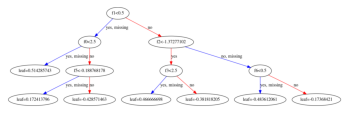

In [10]:
#plot one tree
plot_tree(pipeline.named_steps['model'])

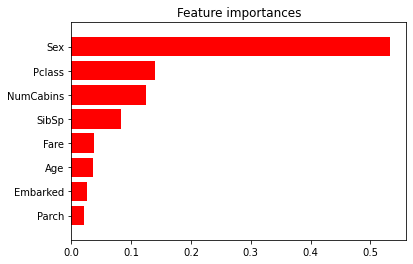

In [11]:
importances = pipeline.named_steps['model'].feature_importances_
indices = np.argsort(importances)
# std = np.std([tree.feature_importances_ for tree in forest.estimators_],
#              axis=0)
n_ft = len(importances)

plt.figure()
plt.title("Feature importances")
plt.barh(range(n_ft), importances[indices],
         color="r",
         #xerr=std[indices],
         align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(n_ft), df_train_val.columns[indices])
plt.ylim([-1, n_ft])
plt.show()

# Stochastic gradient boosting
## Row subsampling
- when making a new tree
- use `subsample`

In [33]:
def check_params(params):
    pipeline = Pipeline(steps=[
        ("preproc", Preprocessor(df_train.columns)),
        ("model", XGBClassifier(**params)),
    ])
    # check cross-validation
    kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)
    results = cross_val_score(pipeline, df_train_val.values, y, cv=kfold,
                fit_params=dict(model__eval_metric='logloss'))
    print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
    return pipeline

In [34]:
# best so far
params = dict(
    objective = 'binary:logistic',
    use_label_encoder = False,
    max_depth = 3,
    colsample_bylevel = .8,
    reg_alpha = .5,
    learning_rate = .3,
)
pipeline = check_params(params)

Accuracy: 83.73% (0.84%)


In [39]:
# best so far
params = dict(
    objective = 'binary:logistic',
    use_label_encoder = False,
    max_depth = 3,
    colsample_bylevel = .8,
    reg_alpha = .5,
    learning_rate = .3,
    tree_method = 'hist',
    max_bin = 150,
)
check_params(params)

Accuracy: 83.39% (1.38%)


Pipeline(steps=[('preproc', <__main__.Preprocessor object at 0x7fa2047337c0>),
                ('model',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=0.8, colsample_bynode=None,
                               colsample_bytree=None, gamma=None, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_bin=150, max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, reg_alpha=0.5,
                               reg_lambda=None, scale_pos_weight=None,
                               subsample=None, tree_method='hist',
                               use_label_encoder=F

In [107]:
subsample = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
param_grid = dict(model__subsample=subsample, model__eval_metric=['logloss'])
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)
grid_search = GridSearchCV(pipeline, param_grid,
        scoring="accuracy", n_jobs=-1, cv=kfold, verbose=2)
grid_result = grid_search.fit(df_train_val.values, y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


Best: 0.832772 using {'model__eval_metric': 'logloss', 'model__subsample': 1.0}
0.814815 (0.010997) with: {'model__eval_metric': 'logloss', 'model__subsample': 0.1}
0.818182 (0.013746) with: {'model__eval_metric': 'logloss', 'model__subsample': 0.2}
0.831650 (0.009523) with: {'model__eval_metric': 'logloss', 'model__subsample': 0.3}
0.817059 (0.009655) with: {'model__eval_metric': 'logloss', 'model__subsample': 0.4}
0.818182 (0.011983) with: {'model__eval_metric': 'logloss', 'model__subsample': 0.5}
0.823793 (0.009655) with: {'model__eval_metric': 'logloss', 'model__subsample': 0.6}
0.822671 (0.014108) with: {'model__eval_metric': 'logloss', 'model__subsample': 0.7}
0.824916 (0.007274) with: {'model__eval_metric': 'logloss', 'model__subsample': 0.8}
0.832772 (0.007936) with: {'model__eval_metric': 'logloss', 'model__subsample': 1.0}


Text(0, 0.5, 'Log Loss')

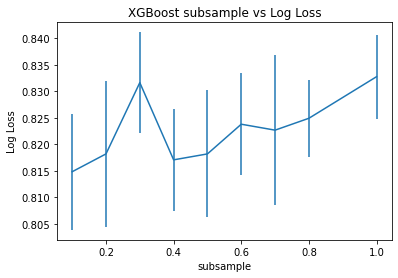

In [108]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
# plot
plt.errorbar(subsample, means, yerr=stds)
plt.title("XGBoost subsample vs Log Loss")
plt.xlabel('subsample')
plt.ylabel('Log Loss')
# plt.savefig('colsample_bytree.png')


In [98]:
grid_result.best_estimator_

Pipeline(steps=[('preproc', <__main__.Preprocessor object at 0x7fa4b1ed98b0>),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eval_metric='logloss',
                               gamma=0, gpu_id=-1, importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=3, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1.0, tree_method='exact',
                               use_label_encoder=False, validate_parameters=1,
                   

## Feature subsampling for each tree
- use `colsample_bytree`

In [99]:
colsample_bytree = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
param_grid = dict(model__colsample_bytree=colsample_bytree, model__eval_metric=['logloss'])
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
grid_search = GridSearchCV(pipeline, param_grid,
        scoring="accuracy", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(df_train_val.values, y)

Best: 0.829377 using {'model__colsample_bytree': 1.0, 'model__eval_metric': 'logloss'}
0.810276 (0.023978) with: {'model__colsample_bytree': 0.1, 'model__eval_metric': 'logloss'}
0.810276 (0.023978) with: {'model__colsample_bytree': 0.2, 'model__eval_metric': 'logloss'}
0.818141 (0.022900) with: {'model__colsample_bytree': 0.3, 'model__eval_metric': 'logloss'}
0.815912 (0.020108) with: {'model__colsample_bytree': 0.4, 'model__eval_metric': 'logloss'}
0.815919 (0.020682) with: {'model__colsample_bytree': 0.5, 'model__eval_metric': 'logloss'}
0.815919 (0.020682) with: {'model__colsample_bytree': 0.6, 'model__eval_metric': 'logloss'}
0.820413 (0.015628) with: {'model__colsample_bytree': 0.7, 'model__eval_metric': 'logloss'}
0.822648 (0.025909) with: {'model__colsample_bytree': 0.8, 'model__eval_metric': 'logloss'}
0.829377 (0.021685) with: {'model__colsample_bytree': 1.0, 'model__eval_metric': 'logloss'}


Text(0, 0.5, 'Log Loss')

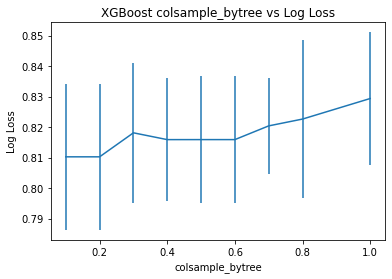

In [100]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
# plot
plt.errorbar(colsample_bytree, means, yerr=stds)
plt.title("XGBoost colsample_bytree vs Log Loss")
plt.xlabel('colsample_bytree')
plt.ylabel('Log Loss')
# plt.savefig('colsample_bytree.png')

## Feature subsampling for each split in tree
- use `colsample_bylevel`

In [102]:
colsample_bylevel = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
param_grid = dict(model__colsample_bylevel=colsample_bylevel, model__eval_metric=['logloss'])
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
grid_search = GridSearchCV(pipeline, param_grid,
        scoring="accuracy", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(df_train_val.values, y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


Best: 0.830507 using {'model__colsample_bylevel': 0.8, 'model__eval_metric': 'logloss'}
0.819277 (0.020120) with: {'model__colsample_bylevel': 0.1, 'model__eval_metric': 'logloss'}
0.819277 (0.020120) with: {'model__colsample_bylevel': 0.2, 'model__eval_metric': 'logloss'}
0.827129 (0.016706) with: {'model__colsample_bylevel': 0.3, 'model__eval_metric': 'logloss'}
0.823784 (0.011702) with: {'model__colsample_bylevel': 0.4, 'model__eval_metric': 'logloss'}
0.820400 (0.014921) with: {'model__colsample_bylevel': 0.5, 'model__eval_metric': 'logloss'}
0.820400 (0.014921) with: {'model__colsample_bylevel': 0.6, 'model__eval_metric': 'logloss'}
0.819289 (0.025813) with: {'model__colsample_bylevel': 0.7, 'model__eval_metric': 'logloss'}
0.830507 (0.023540) with: {'model__colsample_bylevel': 0.8, 'model__eval_metric': 'logloss'}
0.829377 (0.021685) with: {'model__colsample_bylevel': 1.0, 'model__eval_metric': 'logloss'}


Text(0, 0.5, 'Log Loss')

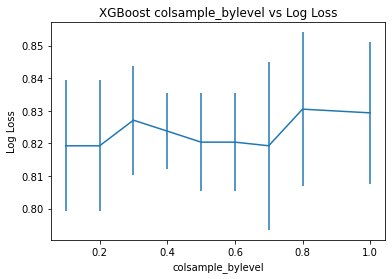

In [103]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
# plot
plt.errorbar(colsample_bylevel, means, yerr=stds)
plt.title("XGBoost colsample_bylevel vs Log Loss")
plt.xlabel('colsample_bylevel')
plt.ylabel('Log Loss')
# plt.savefig('colsample_bylevel.png')

## colsample_bynode

In [111]:
print(pipeline)

Pipeline(steps=[('preproc', <__main__.Preprocessor object at 0x7fa4feeed520>),
                ('model',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=0.8, colsample_bynode=None,
                               colsample_bytree=None, gamma=None, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, reg_alpha=None,
                               reg_lambda=None, scale_pos_weight=None,
                               subsample=None, tree_method=None,
                               use_label_encoder=False,
       

In [112]:
colsample_bynode = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
param_grid = dict(model__colsample_bynode=colsample_bynode, model__eval_metric=['logloss'])
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)
grid_search = GridSearchCV(pipeline, param_grid,
        scoring="accuracy", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(df_train_val.values, y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


Best: 0.832772 using {'model__colsample_bynode': 1.0, 'model__eval_metric': 'logloss'}
0.814815 (0.015307) with: {'model__colsample_bynode': 0.1, 'model__eval_metric': 'logloss'}
0.814815 (0.015307) with: {'model__colsample_bynode': 0.2, 'model__eval_metric': 'logloss'}
0.814815 (0.015307) with: {'model__colsample_bynode': 0.3, 'model__eval_metric': 'logloss'}
0.813692 (0.011446) with: {'model__colsample_bynode': 0.4, 'model__eval_metric': 'logloss'}
0.830527 (0.001587) with: {'model__colsample_bynode': 0.5, 'model__eval_metric': 'logloss'}
0.830527 (0.001587) with: {'model__colsample_bynode': 0.6, 'model__eval_metric': 'logloss'}
0.831650 (0.012598) with: {'model__colsample_bynode': 0.7, 'model__eval_metric': 'logloss'}
0.831650 (0.012598) with: {'model__colsample_bynode': 0.8, 'model__eval_metric': 'logloss'}
0.832772 (0.007936) with: {'model__colsample_bynode': 1.0, 'model__eval_metric': 'logloss'}


Text(0, 0.5, 'Log Loss')

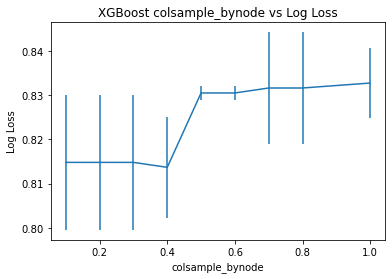

In [113]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
# plot
plt.errorbar(colsample_bynode, means, yerr=stds)
plt.title("XGBoost colsample_bynode vs Log Loss")
plt.xlabel('colsample_bynode')
plt.ylabel('Log Loss')
# plt.savefig('colsample_bylevel.png')

In [121]:
def do_grid_search(pipeline, param_grid, x, y, plot_param=None):
    kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)
    grid_search = GridSearchCV(pipeline, param_grid,
            scoring="accuracy", n_jobs=-1, cv=kfold, verbose=2)
    grid_result = grid_search.fit(x, y)
    
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

    # plot
    if plot_param is not None:
        plt.errorbar(param_grid[f'model__{plot_param}'], means, yerr=stds)
        plt.title(f"XGBoost {plot_param} vs Log Loss")
        plt.xlabel(plot_param)
        plt.ylabel('Log Loss')
        # plt.savefig('colsample_bylevel.png')
        
    return grid_result

Pipeline(steps=[('preproc', <__main__.Preprocessor object at 0x7fa4feeed520>),
                ('model',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=0.8, colsample_bynode=None,
                               colsample_bytree=None, gamma=None, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, reg_alpha=None,
                               reg_lambda=None, scale_pos_weight=None,
                               subsample=None, tree_method=None,
                               use_label_encoder=False,
       

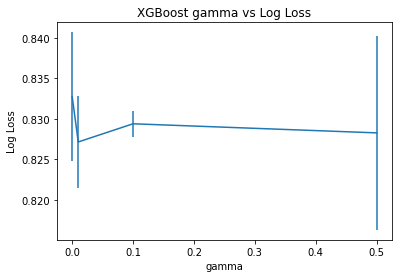

In [123]:
print(pipeline)
param_grid = dict(
    model__gamma=[0, .01, .1, .5],
    model__eval_metric=['logloss'])
grid_result = do_grid_search(
    pipeline, param_grid, df_train_val.values, y, plot_param='gamma')

In [124]:
print(pipeline)
param_grid = dict(
    model__reg_alpha=[0, .01, .1, .5, 1],
    model__reg_lambda=[0, .01, .1, .5, 1],
    model__eval_metric=['logloss'])
grid_result = do_grid_search(
    pipeline, param_grid, df_train_val.values, y)

Pipeline(steps=[('preproc', <__main__.Preprocessor object at 0x7fa4feeed520>),
                ('model',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=0.8, colsample_bynode=None,
                               colsample_bytree=None, gamma=None, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, reg_alpha=None,
                               reg_lambda=None, scale_pos_weight=None,
                               subsample=None, tree_method=None,
                               use_label_encoder=False,
       